In [1]:
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import argparse
import pickle
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

plt.style.use('ggplot')
plt.figure(figsize=(12,8), dpi= 100)
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

<Figure size 1200x800 with 0 Axes>

## Preprocessing
### Lending Data

In [2]:
data_dir = "../data/lending_data/"
skip_files = {"aave.csv", "maker.csv"}
datasets = [str(f) for f in listdir(data_dir) if isfile(join(data_dir, 
                                                             f)) and str(f) not in skip_files]
money_market_dfs = {dataset[:-4] : pd.read_csv(data_dir+dataset, index_col=0)  for dataset in datasets}    

def impute_data(df, start):
    """
    impute the data for the dates between start and the beginning
    of the dataset using the head rows of the dataset
    """
    start_date = datetime.strptime(start,"%Y-%m-%d").date()
    df_start_date = df.index[0]
    ndays = (df_start_date - start_date).days
    if ndays <= 0:
        return df
    assert len(df) >= 180, len(df)
    df2 = df[:90].copy()
    while len(df2) < ndays:
        df2 = df2.append(df2)
    df2 = df2[:ndays]
    df2.index = [start_date+timedelta(i) for i in range(ndays)]
    return df2.append(df)

def merge_dfs(dfs, return_col): 
    """
    merge return cols of dfs based on index column. take rolling
    mean of 7 days and return the resulting df
    """
    merged_df = None
    for name, df in dfs.items():
        df = df.rename(columns={f"{return_col}": name})[[name]]
        merged_df = (
            df if merged_df is None
            else pd.merge(merged_df, df, left_index=True, right_index=True, how="inner")
        )
    merged_df = merged_df.rolling(7, min_periods=1).mean()
    return merged_df

for market, df in money_market_dfs.items():
    x_values = [datetime.strptime(d,"%Y-%m-%d").date() for d in df.index]
    df.index = x_values
    # reverse the dataframe so that most recent data is at the tail
    money_market_dfs[market] = df.iloc[::-1]
    print(market, min(x_values))

print("\n==compound==")
money_market_dfs["compound"].head()

compound 2019-07-17
c_r_e_a_m_-finance 2020-08-25
definer 2020-11-03
dydx 2019-05-09

==compound==


,lend_rate,borrow_rate
2019-07-17,9.953725,13.775127
2019-07-18,11.207770,14.420475
2019-07-19,11.045261,14.384209
2019-07-20,13.987419,17.229919
2019-07-21,12.805582,16.663595


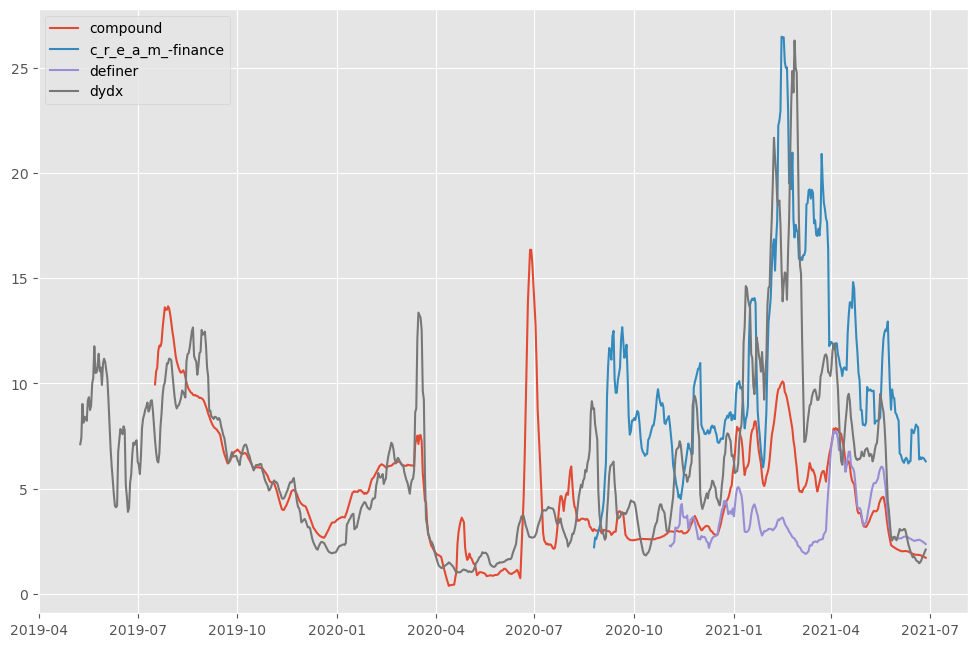

In [3]:
for k, df in money_market_dfs.items():
    x_values = df.index
    y_values = df["lend_rate"].rolling(7, min_periods=1).mean()
    plt.plot(x_values, y_values, '-', label=k)
plt.legend()
plt.show()

In [4]:
# impute data
start_date = '2018-07-17'
for market in money_market_dfs.keys():
    money_market_dfs[market] = impute_data(money_market_dfs[market], start_date)

In [5]:
lend_rates_df = merge_dfs(money_market_dfs, "lend_rate")
lend_rates_df["nexo"] = 12.0 # usdc, usdt
lend_rates_df["celsius"] = 8.8 # usdc, usdt
lend_rates_df.head(10)

,compound,c_r_e_a_m_-finance,definer,dydx,nexo,celsius
2018-07-17,9.953725,2.217519,2.291264,7.112444,12.0,8.8
2018-07-18,10.580748,2.681616,2.254303,7.399786,12.0,8.8
2018-07-19,10.735585,2.604717,2.355577,9.025901,12.0,8.8
2018-07-20,11.548544,3.345249,2.391229,8.136644,12.0,8.8
2018-07-21,11.799951,3.709076,2.478293,8.417178,12.0,8.8
2018-07-22,11.755153,3.962528,3.154735,8.356184,12.0,8.8
2018-07-23,11.953517,4.448069,3.137502,8.224478,12.0,8.8
2018-07-24,12.628699,5.427358,3.119819,9.190747,12.0,8.8
2018-07-25,13.140014,6.260726,3.191847,9.347148,12.0,8.8
2018-07-26,13.613733,9.393201,3.315871,8.735714,12.0,8.8


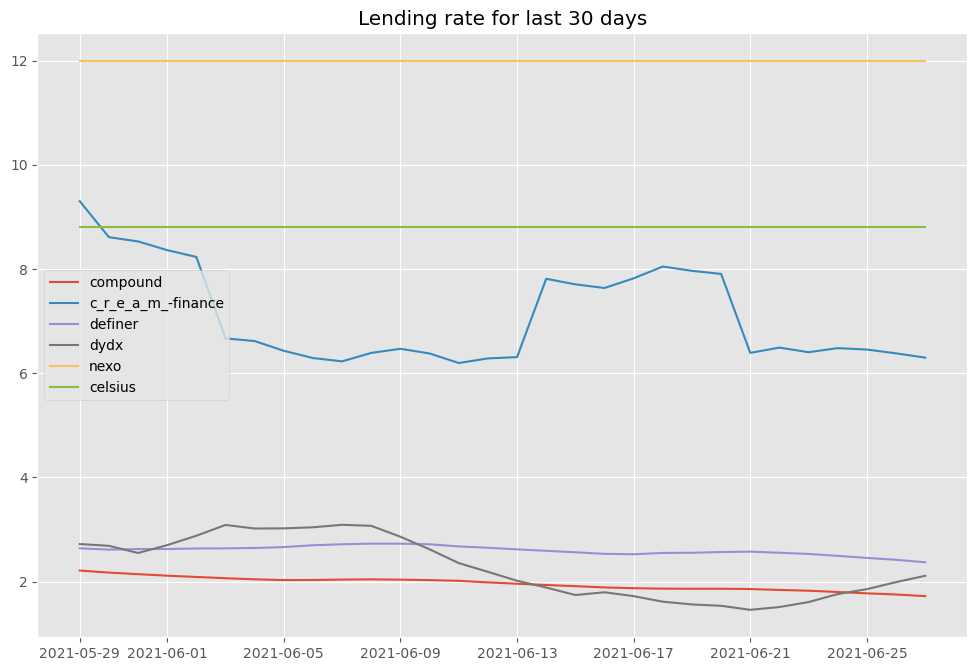

In [6]:
temp_df = lend_rates_df.tail(30)
for col in temp_df.columns:
    y_values = temp_df[col]    
    plt.plot(temp_df.index, y_values, '-', label=col)
plt.legend()
plt.title("Lending rate for last 30 days")
plt.show()

lending rates: 7 days rolling avg


<AxesSubplot:>

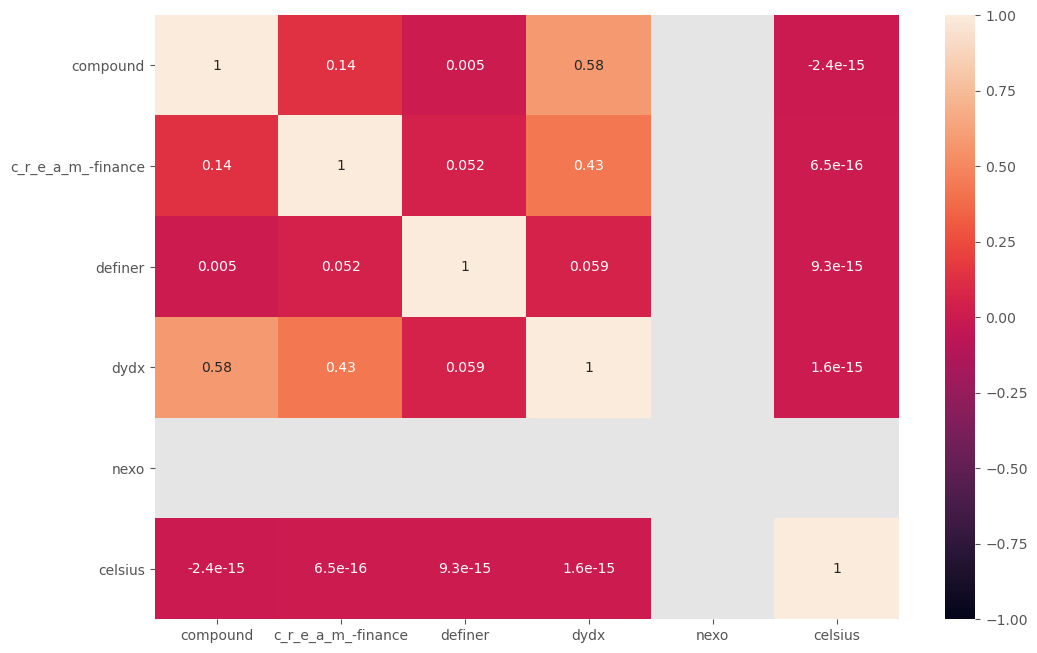

In [7]:
print("lending rates: 7 days rolling avg")
sns.heatmap(lend_rates_df.corr(), vmin=-1, vmax=1, annot=True)

lending rates: 7 days rolling avg for last 30 days


<AxesSubplot:>

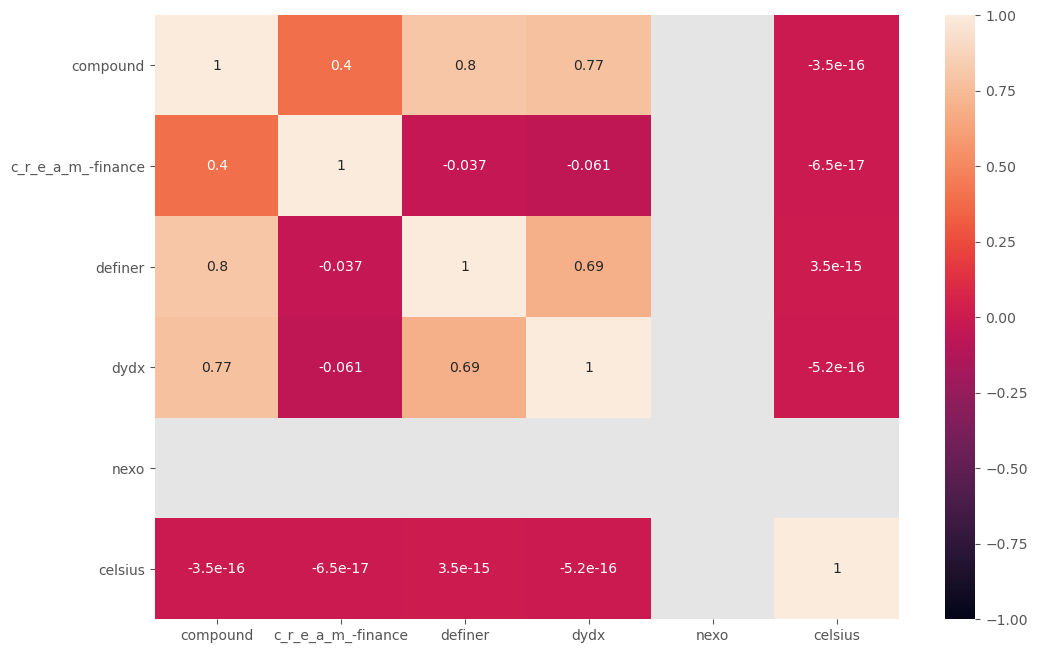

In [8]:
print("lending rates: 7 days rolling avg for last 30 days")
sns.heatmap(lend_rates_df.tail(30).corr(), vmin=-1, vmax=1, annot=True)

In [9]:
lend_rates_df.std()

compound              3.298133e+00
c_r_e_a_m_-finance    3.181832e+00
definer               8.799024e-01
dydx                  3.746890e+00
nexo                  0.000000e+00
celsius               1.421748e-14
dtype: float64

In [10]:
# start with $1, and apply daily yield each day to convert
# lend rates to lending protocol (lp) returns
lp_returns = {market : [1] for market in lend_rates_df.columns}
for i, date in enumerate(lend_rates_df.index):
    if i == len(lend_rates_df.index) - 1:
        continue
    for market, returns in lp_returns.items():
        daily_yield = (1+lend_rates_df[market][i]/100)**(1/365)-1
        returns.append(returns[-1]*(1+daily_yield))   
lp_returns_df = pd.DataFrame(lp_returns, index=lend_rates_df.index)
lp_returns_df.head(10)

,compound,c_r_e_a_m_-finance,definer,dydx,nexo,celsius
2018-07-17,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2018-07-18,1.000260,1.000060,1.000062,1.000188,1.000311,1.000231
2018-07-19,1.000536,1.000133,1.000123,1.000384,1.000621,1.000462
2018-07-20,1.000815,1.000203,1.000187,1.000621,1.000932,1.000693
2018-07-21,1.001115,1.000293,1.000252,1.000835,1.001243,1.000925
2018-07-22,1.001421,1.000393,1.000319,1.001057,1.001554,1.001156
2018-07-23,1.001726,1.000500,1.000404,1.001277,1.001865,1.001387
2018-07-24,1.002036,1.000619,1.000489,1.001494,1.002176,1.001619
2018-07-25,1.002362,1.000764,1.000573,1.001735,1.002487,1.001850
2018-07-26,1.002701,1.000930,1.000659,1.001980,1.002798,1.002082


In [11]:
lp_returns_df.tail(10)

,compound,c_r_e_a_m_-finance,definer,dydx,nexo,celsius
2021-06-18,1.193162,1.280956,1.104320,1.211042,1.391470,1.278721
2021-06-19,1.193222,1.281228,1.104396,1.211095,1.391902,1.279016
2021-06-20,1.193282,1.281497,1.104472,1.211147,1.392335,1.279312
2021-06-21,1.193343,1.281764,1.104549,1.211197,1.392767,1.279608
2021-06-22,1.193403,1.281981,1.104626,1.211245,1.393199,1.279903
2021-06-23,1.193462,1.282202,1.104702,1.211295,1.393632,1.280199
2021-06-24,1.193521,1.282420,1.104778,1.211348,1.394065,1.280495
2021-06-25,1.193580,1.282641,1.104852,1.211406,1.394498,1.280791
2021-06-26,1.193637,1.282861,1.104925,1.211467,1.394931,1.281087
2021-06-27,1.193694,1.283078,1.104998,1.211532,1.395364,1.281383


### Coin Data

In [12]:
data_dir = "../data/coin_data/"
exclude = {'markets.csv'}

datasets = [str(f) for f in listdir(data_dir) if isfile(join(data_dir, f)) and str(f) not in exclude]

datasets = [ 'binancecoin.csv', 'bitcoin-cash.csv', 'bitcoin.csv', 
            'cardano.csv', 'celsius-degree-token.csv', 'chainlink.csv',
            'decred.csv', 'dogecoin.csv', 'eos.csv', 'ethereum-classic.csv', 'ethereum.csv', 
            'litecoin.csv', 'monero.csv', 'neo.csv', 'ripple.csv', 'tether.csv', 'tron.csv', 
            'usd-coin.csv']

coin_dfs = {dataset[:-4] : pd.read_csv(data_dir+dataset, index_col=2)  for dataset in datasets}
print("coin name\tdata start")
for k, df in coin_dfs.items():
    try: 
        x_values = [datetime.strptime(d,"%Y-%m-%d %H:%M:%S.%f").date() for d in df.index]
    except ValueError:
        x_values = [datetime.strptime(d,"%Y-%m-%d %H:%M:%S").date() for d in df.index]
    df.index = x_values
    print(k, min(x_values), sep="\t")
    df.drop(columns=['timestamp'], inplace=True)

print("\n===Bitcoin===")
coin_dfs["bitcoin"].tail(10)

coin name	data start
binancecoin	2017-09-16
bitcoin-cash	2017-08-02
bitcoin	2013-04-28
cardano	2017-10-18
celsius-degree-token	2018-10-12
chainlink	2017-11-09
decred	2016-02-10
dogecoin	2013-12-15
eos	2017-07-09
ethereum-classic	2016-07-24
ethereum	2015-08-07
litecoin	2013-04-28
monero	2014-05-21
neo	2016-09-09
ripple	2013-08-04
tether	2015-02-25
tron	2017-11-09
usd-coin	2018-10-05

===Bitcoin===


,price
2021-06-20,35581.642268
2021-06-21,35787.077405
2021-06-22,31711.935468
2021-06-23,32507.738707
2021-06-24,33702.617794
2021-06-25,34675.449105
2021-06-26,31943.136468
2021-06-27,32023.973902
2021-06-28,34607.293274
2021-06-29,35822.604653


In [13]:
coin_df = merge_dfs(coin_dfs, 'price')
coin_df.head(10)

,binancecoin,bitcoin-cash,bitcoin,cardano,celsius-degree-token,chainlink,decred,dogecoin,eos,ethereum-classic,ethereum,litecoin,monero,neo,ripple,tether,tron,usd-coin
2018-10-12,9.289350,435.054926,6234.367641,0.071003,0.048109,0.309131,36.761016,0.005058,5.111751,9.187471,192.001084,51.302149,102.323932,15.561041,0.382766,0.998606,0.021085,1.007660
2018-10-13,9.419459,440.438874,6259.980312,0.072269,0.047092,0.311240,36.642086,0.005168,5.157928,9.363996,194.534550,52.518679,102.562065,15.638773,0.402022,0.998359,0.021999,1.007961
2018-10-14,9.483401,444.801487,6278.281336,0.072766,0.051438,0.314812,37.382821,0.005191,5.203898,9.437160,196.707533,52.989528,103.279257,15.738953,0.408726,0.998150,0.022604,1.009879
2018-10-15,9.507230,444.295339,6290.849692,0.072494,0.054497,0.318720,37.492084,0.005199,5.202798,9.449719,196.610325,52.862561,102.824114,15.749898,0.407852,0.997618,0.022907,1.013563
2018-10-16,9.699197,448.753504,6364.654855,0.073138,0.055425,0.323756,38.069422,0.005233,5.274874,9.542887,199.728874,53.425556,103.541633,15.901272,0.416886,0.995206,0.023397,1.018422
2018-10-17,9.774544,451.423513,6409.733324,0.073782,0.055315,0.330491,38.434539,0.005212,5.313855,9.597339,201.848109,53.679325,104.253571,16.025854,0.426707,0.993090,0.023610,1.021816
2018-10-18,9.823962,452.383111,6442.020254,0.074494,0.054873,0.338057,38.672273,0.005137,5.343696,9.656101,203.167335,53.834580,104.845168,16.168846,0.433734,0.992463,0.023761,1.023474
2018-10-19,9.904106,453.355113,6482.469318,0.075179,0.054846,0.347887,39.019819,0.005050,5.385791,9.727990,204.926187,54.054260,105.020905,16.332431,0.444975,0.990898,0.024247,1.025104
2018-10-20,9.947283,453.240038,6510.788573,0.075590,0.054986,0.355110,39.330068,0.004945,5.410785,9.748316,205.913080,54.008449,105.347986,16.465810,0.450174,0.990405,0.024437,1.026142
2018-10-21,9.985604,453.149965,6541.902197,0.076091,0.053331,0.362066,39.323172,0.004856,5.430767,9.776025,206.745737,54.007910,105.285962,16.594812,0.456185,0.989778,0.024519,1.029147


coin price in last 15 months: 7 days rolling avg


<AxesSubplot:>

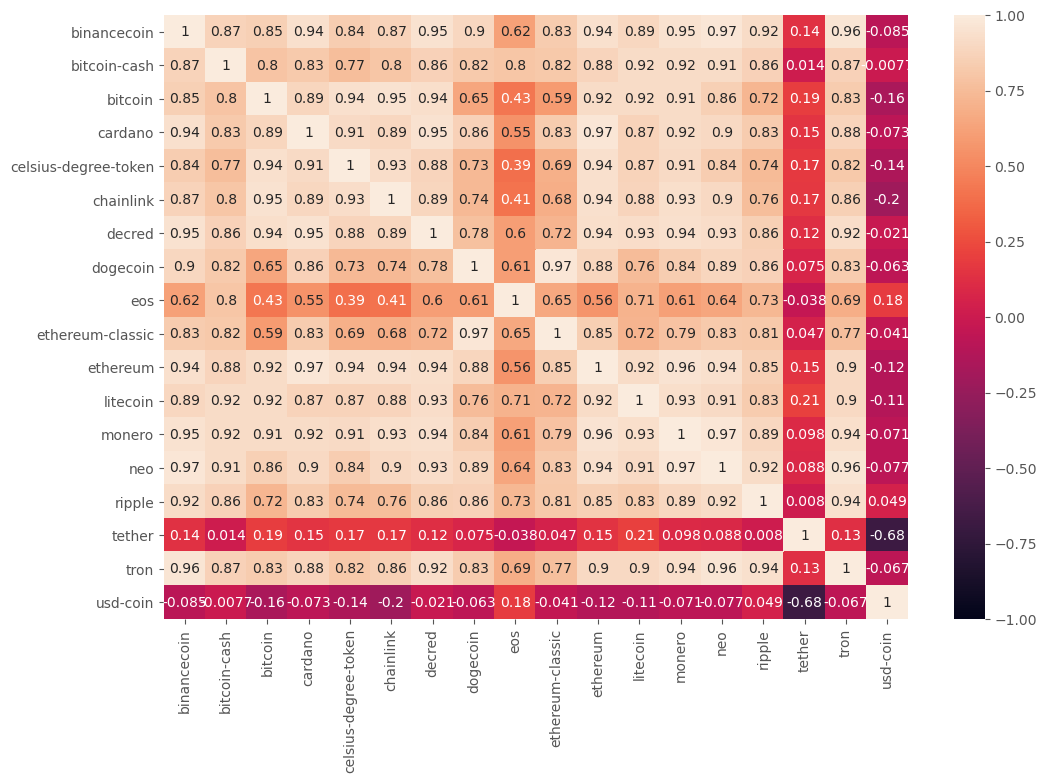

In [14]:
print("coin price in last 15 months: 7 days rolling avg")
sns.heatmap(coin_df.corr(), vmin=-1, vmax=1, annot=True)

coin price in last 15 months: 7 days rolling avg


Text(0.5, 1.0, 'Nov 07 2020 - Apr 07 2020')

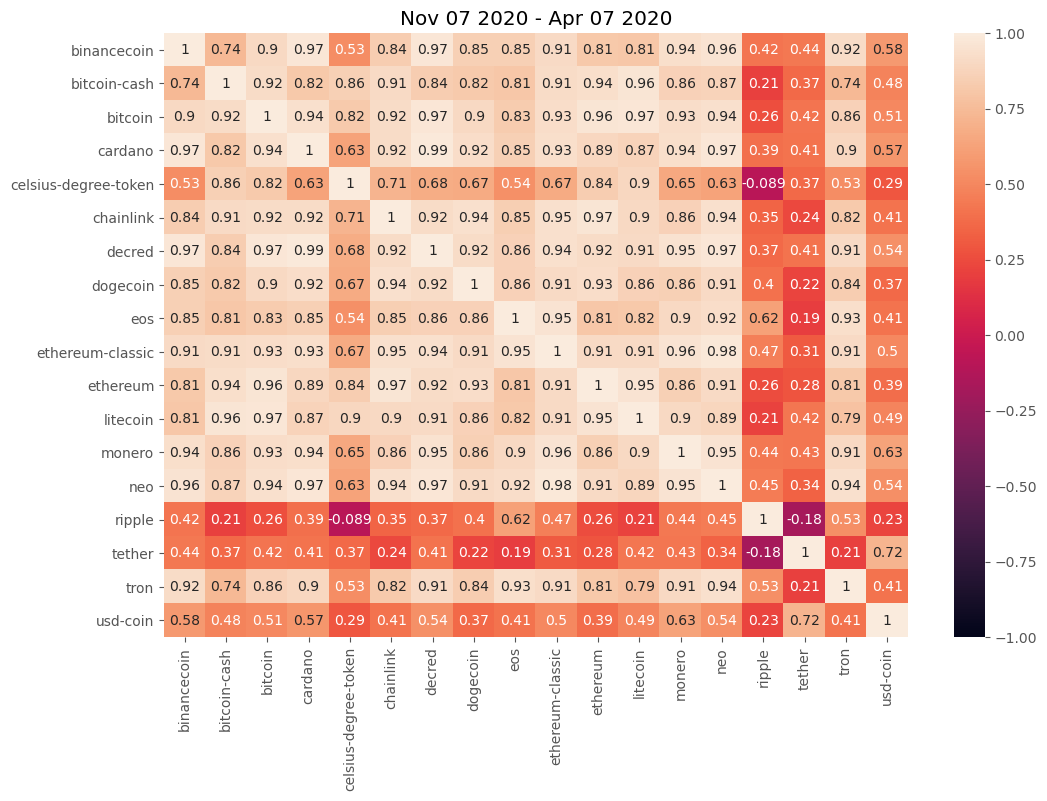

In [15]:
print("coin price in last 15 months: 7 days rolling avg")
temp_df = coin_df[(coin_df.index > datetime.strptime('2020-11-07', '%Y-%m-%d').date()
                  ) & (coin_df.index < datetime.strptime('2021-04-07', '%Y-%m-%d').date())]
temp_df
sns.heatmap(temp_df.corr(), vmin=-1, vmax=1, annot=True)
plt.title("Nov 07 2020 - Apr 07 2020")

In [16]:
# dividing by the mean because the coin prices are not on the same scale. 
# This is the relative volatility of various coins
(coin_df/coin_df.mean()).std()

binancecoin             1.916484
bitcoin-cash            0.581528
bitcoin                 0.991322
cardano                 1.754304
celsius-degree-token    1.670682
chainlink               1.273146
decred                  1.222354
dogecoin                2.906225
eos                     0.401013
ethereum-classic        1.480202
ethereum                1.369206
litecoin                0.730551
monero                  0.743840
neo                     1.022865
ripple                  0.703654
tether                  0.002541
tron                    0.843336
usd-coin                0.004888
dtype: float64

## Portfolio Optimization
### Low Risk: Only lending protocols

In [29]:
def generate_roi(weights, assets_df, plot=True, rebalance_period=1):
    """
    given the asset weights, generate the return on investment
    rebalances on the first day of each rebalance_period
    """
    returns = []
    investment = 100
    if rebalance_period > 0:
        i = 0
        while i < len(assets_df):
            # rebalance_period+1 because need to calculate the net value of
            # of the investment on the first day of next period
            # 
            period_df = assets_df.iloc[i:i+rebalance_period+1]
            period_returns = 0
            for asset, weight in weights.items():
                # on the first day of each period the portfolio is rebalanced
                period_returns += (period_df[asset]/period_df[asset][0])*weight*investment
            # add the returns for the period, and skip the last index
            returns += list(period_returns)[:-1]      
            # investment value on the first day of next period
            investment = list(period_returns)[-1]
            i += rebalance_period    
    returns.append(investment)
    roi = [r - 100 for r in returns]
    if plot:
        plt.plot(assets_df.index, roi, '--', label="portfolio")
        for asset in assets_df.columns:
            roi_asset = (assets_df[asset]/assets_df[asset][0])*100 - 100
            x, y = assets_df.index, roi_asset
            plt.plot(x, y, label=asset)
            plt.annotate(text=asset, xy= (x[-1], y[-1]), fontsize=8)
        plt.legend()
    return roi

def evaluation(weights, assets_df, rebalance_period):
    # expected return
    mu = mean_historical_return(assets_df, frequency=365)
    # covariance matrix
    S = risk_matrix(assets_df, method='ledoit_wolf', frequency=365)
    _ = portfolio_performance(
        weights, mu, S, verbose=True, risk_free_rate=0.02
    )
    roi = generate_roi(weights, assets_df, plot=True, rebalance_period=rebalance_period)
    return roi
    

split_date = '2021-02-10'

# split data into train and test
train_df = lp_returns_df[lp_returns_df.index < datetime.strptime(split_date, '%Y-%m-%d').date()]
test_df = lp_returns_df[lp_returns_df.index >= datetime.strptime(split_date, '%Y-%m-%d').date()]

train_df.head(10)

,compound,c_r_e_a_m_-finance,definer,dydx,nexo,celsius
2018-07-17,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2018-07-18,1.000260,1.000060,1.000062,1.000188,1.000311,1.000231
2018-07-19,1.000536,1.000133,1.000123,1.000384,1.000621,1.000462
2018-07-20,1.000815,1.000203,1.000187,1.000621,1.000932,1.000693
2018-07-21,1.001115,1.000293,1.000252,1.000835,1.001243,1.000925
2018-07-22,1.001421,1.000393,1.000319,1.001057,1.001554,1.001156
2018-07-23,1.001726,1.000500,1.000404,1.001277,1.001865,1.001387
2018-07-24,1.002036,1.000619,1.000489,1.001494,1.002176,1.001619
2018-07-25,1.002362,1.000764,1.000573,1.001735,1.002487,1.001850
2018-07-26,1.002701,1.000930,1.000659,1.001980,1.002798,1.002082


mean (yearly) return:
compound              0.063946
c_r_e_a_m_-finance    0.082672
definer               0.034000
dydx                  0.064688
nexo                  0.120000
celsius               0.088000
dtype: float64

---portfolio weights---
OrderedDict([('compound', 0.1089157041061826), ('c_r_e_a_m_-finance', 0.232941730556273), ('definer', 0.0468053042940208), ('dydx', 0.1138455633034892), ('nexo', 0.237686049781902), ('celsius', 0.259805647981519)])


Expected annual return: 8.7%
Annual volatility: 0.0%
Sharpe Ratio: 151.22


Text(0.5, 1.0, 'Training set performance')

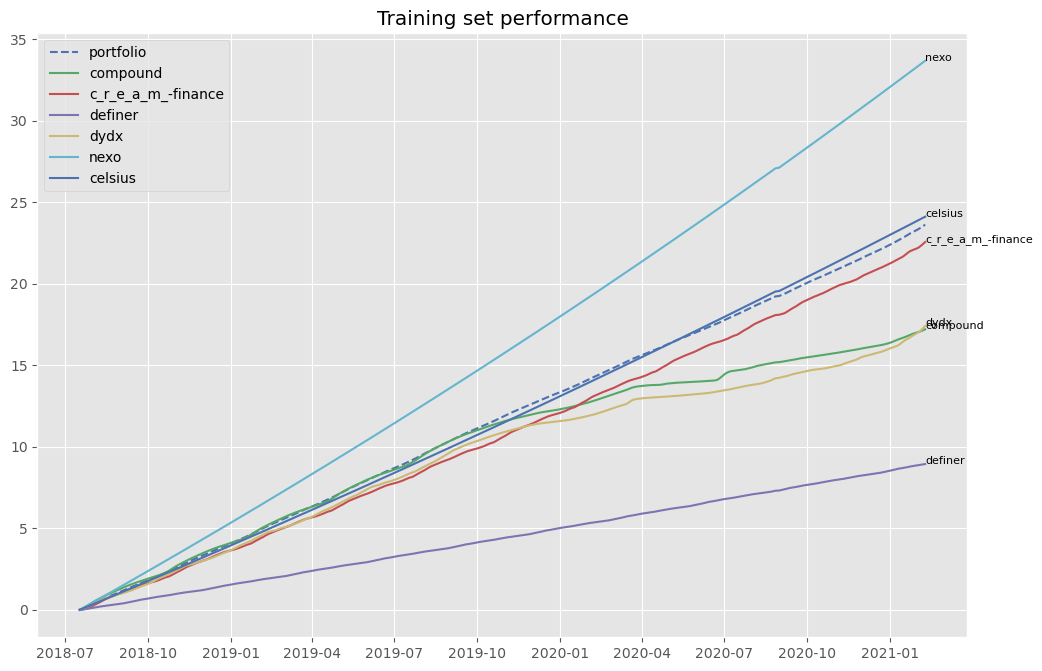

In [18]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import risk_matrix
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import plotting
from pypfopt.base_optimizer import portfolio_performance

# expected return
mu = mean_historical_return(train_df, frequency=365)
# covariance matrix
S = risk_matrix(train_df, method='ledoit_wolf', frequency=365)
print("mean (yearly) return:")
print(mu)
# print("cov matrix (of daily returns):")
# print(S)
ef = EfficientFrontier(mu, S, weight_bounds=(0,1))
# keep no more than 30% in one asset
for i in range(len(train_df.columns)):
    ef.add_constraint(lambda w: w[i] <= 0.3)

low_risk_weights = ef.efficient_return(target_return=0.08)
print("\n---portfolio weights---")
print(low_risk_weights)
print("\n")
_ = evaluation(low_risk_weights, train_df)
plt.title("Training set performance")

Expected annual return: 9.8%
Annual volatility: 0.1%
Sharpe Ratio: 84.53


Text(0.5, 1.0, 'Test set performance')

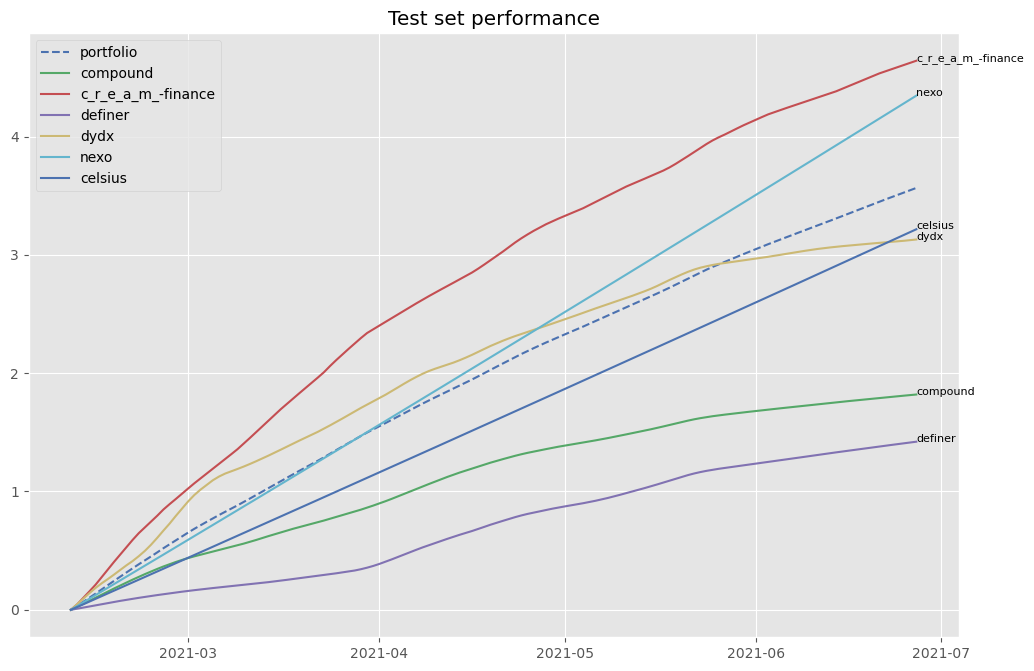

In [19]:
low_risk_roi = evaluation(low_risk_weights, test_df)
plt.title("Test set performance")

## Medium Risk Portfolio
90% lending protocols and (at most) 20% BTC and ETH

In [40]:
# merge coin and lp datasets
assets_df = pd.merge(coin_df[["bitcoin", "ethereum"]], lp_returns_df, 
                     left_index=True, right_index=True, how="inner")
# split data into train and test
train_df = assets_df[assets_df.index < datetime.strptime(split_date, '%Y-%m-%d').date()]
test_df = assets_df[assets_df.index >= datetime.strptime(split_date, '%Y-%m-%d').date()]

train_df.head(10)

,bitcoin,ethereum,compound,c_r_e_a_m_-finance,definer,dydx,nexo,celsius
2018-10-12,6234.367641,192.001084,1.021093,1.018119,1.007998,1.019026,1.027381,1.020307
2018-10-13,6259.980312,194.534550,1.021266,1.018298,1.008080,1.019277,1.027700,1.020542
2018-10-14,6278.281336,196.707533,1.021436,1.018478,1.008161,1.019518,1.028019,1.020778
2018-10-15,6290.849692,196.610325,1.021603,1.018739,1.008243,1.019754,1.028338,1.021014
2018-10-16,6364.654855,199.728874,1.021782,1.018984,1.008323,1.019981,1.028657,1.021250
2018-10-17,6409.733324,201.848109,1.021979,1.019219,1.008401,1.020203,1.028977,1.021486
2018-10-18,6442.020254,203.167335,1.022194,1.019439,1.008479,1.020441,1.029296,1.021722
2018-10-19,6482.469318,204.926187,1.022440,1.019654,1.008555,1.020668,1.029616,1.021958
2018-10-20,6510.788573,205.913080,1.022710,1.019864,1.008628,1.020898,1.029936,1.022195
2018-10-21,6541.902197,206.745737,1.023001,1.020067,1.008712,1.021124,1.030256,1.022431


mean (yearly) return:
bitcoin               1.200939
ethereum              1.525040
compound              0.061231
c_r_e_a_m_-finance    0.083228
definer               0.034042
dydx                  0.062976
nexo                  0.120150
celsius               0.088108
dtype: float64

---portfolio weights---
OrderedDict([('bitcoin', 0.01), ('ethereum', 0.09), ('compound', 0.0), ('c_r_e_a_m_-finance', 0.3), ('definer', 0.0), ('dydx', 0.0), ('nexo', 0.3), ('celsius', 0.3)])


Expected annual return: 23.7%
Annual volatility: 3.7%
Sharpe Ratio: 5.93


Text(0.5, 1.0, 'Training set performance')

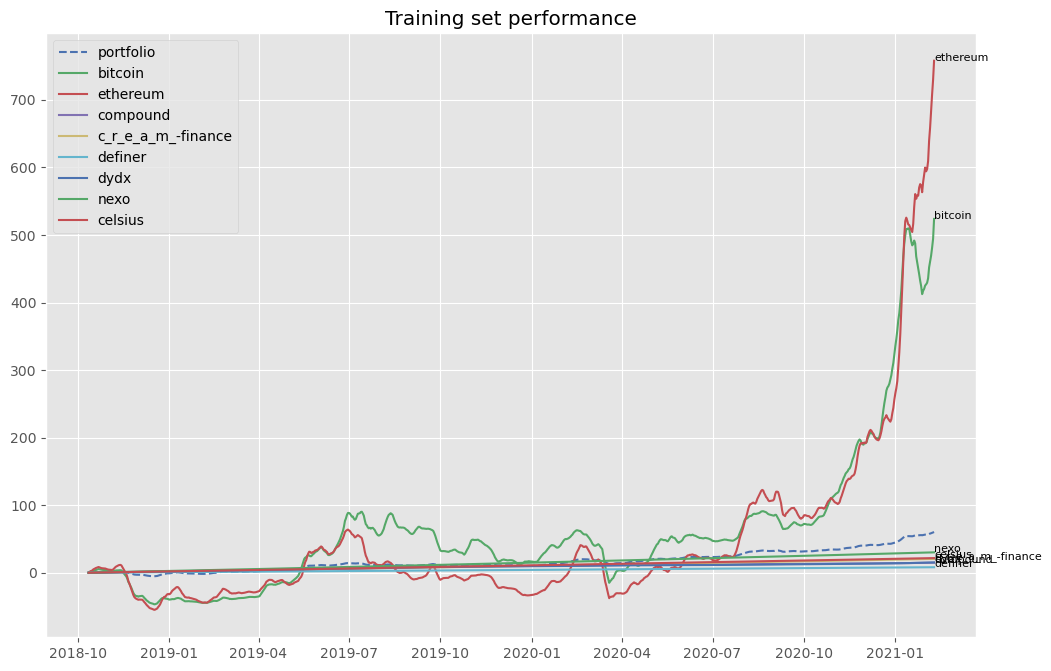

In [45]:
# expected return
mu = mean_historical_return(train_df, frequency=365)
# covariance matrix
S = risk_matrix(train_df, method='ledoit_wolf', frequency=365)
print("mean (yearly) return:")
print(mu)
ef = EfficientFrontier(mu, S, weight_bounds=(0,1))
# w0 is weight for btc and w1 is weight for eth. their sum should not exceed 20%
ef.add_constraint(lambda w: w[0]+w[1] <= 0.1)
# keep some bitcoin, but not too much
ef.add_constraint(lambda w: w[0] >= 0.01)
ef.add_constraint(lambda w: w[0] <= 0.05)
# keep some ethereum
ef.add_constraint(lambda w: w[1] >= 0.01)
ef.add_constraint(lambda w: w[0] <= 0.05)

# keep no more than 30% in one asset
for i in range(len(train_df.columns)):
    ef.add_constraint(lambda w: w[i] <= 0.3)

print("\n---portfolio weights---")
med_risk_weights = ef.efficient_risk(target_volatility=.08)
med_risk_weights =  ef.clean_weights()
print(med_risk_weights)
print("\n")
_ = evaluation(med_risk_weights, train_df, rebalance_period=7)
plt.title("Training set performance")

Expected annual return: 14.0%
Annual volatility: 4.5%
Sharpe Ratio: 2.67


Text(0.5, 1.0, 'Test set performance')

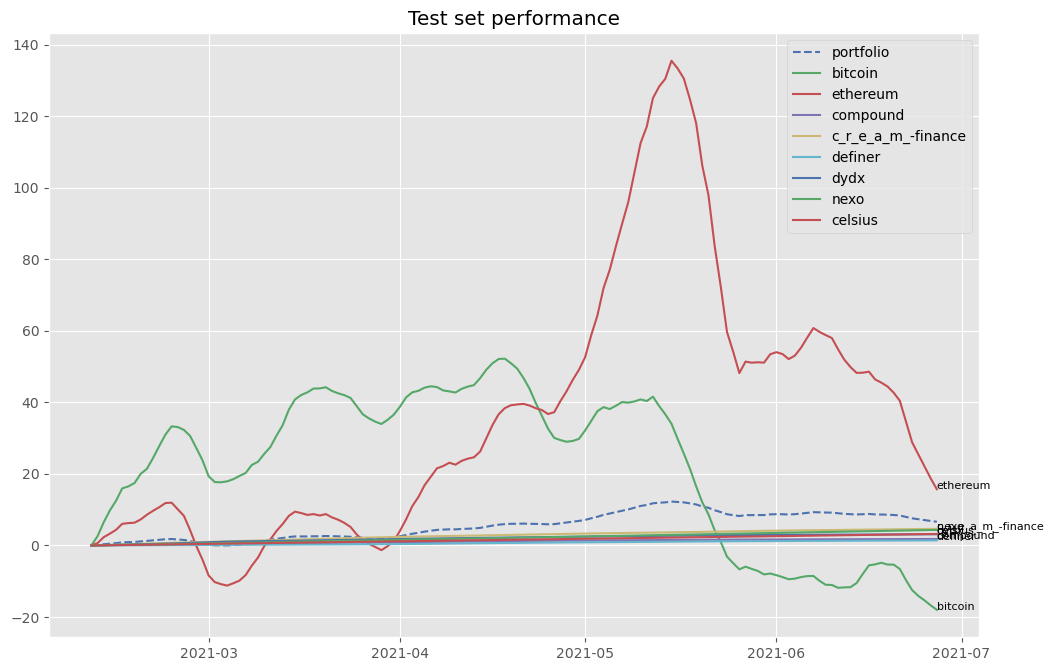

In [46]:
med_risk_roi = evaluation(med_risk_weights, test_df, rebalance_period=7)
plt.title("Test set performance")

## High Risk Portfolio
We add all top tokens and lending protocols and let the model optimize.

In [31]:
# merge coin and lp datasets
assets_df = pd.merge(coin_df[["bitcoin", "ethereum", "cardano", "monero", "litecoin", "dogecoin",
                             "chainlink", "ethereum-classic", "tether", "ripple", "neo", "eos", "tron"]], 
                     lp_returns_df, left_index=True, right_index=True, how="inner")
# split data into train and test
train_df = assets_df[assets_df.index < datetime.strptime(split_date, '%Y-%m-%d').date()]
test_df = assets_df[assets_df.index >= datetime.strptime(split_date, '%Y-%m-%d').date()]

train_df.head(10)

,bitcoin,ethereum,cardano,monero,litecoin,dogecoin,chainlink,ethereum-classic,tether,ripple,neo,eos,tron,compound,c_r_e_a_m_-finance,definer,dydx,nexo,celsius
2018-10-12,6234.367641,192.001084,0.071003,102.323932,51.302149,0.005058,0.309131,9.187471,0.998606,0.382766,15.561041,5.111751,0.021085,1.021093,1.018119,1.007998,1.019026,1.027381,1.020307
2018-10-13,6259.980312,194.534550,0.072269,102.562065,52.518679,0.005168,0.311240,9.363996,0.998359,0.402022,15.638773,5.157928,0.021999,1.021266,1.018298,1.008080,1.019277,1.027700,1.020542
2018-10-14,6278.281336,196.707533,0.072766,103.279257,52.989528,0.005191,0.314812,9.437160,0.998150,0.408726,15.738953,5.203898,0.022604,1.021436,1.018478,1.008161,1.019518,1.028019,1.020778
2018-10-15,6290.849692,196.610325,0.072494,102.824114,52.862561,0.005199,0.318720,9.449719,0.997618,0.407852,15.749898,5.202798,0.022907,1.021603,1.018739,1.008243,1.019754,1.028338,1.021014
2018-10-16,6364.654855,199.728874,0.073138,103.541633,53.425556,0.005233,0.323756,9.542887,0.995206,0.416886,15.901272,5.274874,0.023397,1.021782,1.018984,1.008323,1.019981,1.028657,1.021250
2018-10-17,6409.733324,201.848109,0.073782,104.253571,53.679325,0.005212,0.330491,9.597339,0.993090,0.426707,16.025854,5.313855,0.023610,1.021979,1.019219,1.008401,1.020203,1.028977,1.021486
2018-10-18,6442.020254,203.167335,0.074494,104.845168,53.834580,0.005137,0.338057,9.656101,0.992463,0.433734,16.168846,5.343696,0.023761,1.022194,1.019439,1.008479,1.020441,1.029296,1.021722
2018-10-19,6482.469318,204.926187,0.075179,105.020905,54.054260,0.005050,0.347887,9.727990,0.990898,0.444975,16.332431,5.385791,0.024247,1.022440,1.019654,1.008555,1.020668,1.029616,1.021958
2018-10-20,6510.788573,205.913080,0.075590,105.347986,54.008449,0.004945,0.355110,9.748316,0.990405,0.450174,16.465810,5.410785,0.024437,1.022710,1.019864,1.008628,1.020898,1.029936,1.022195
2018-10-21,6541.902197,206.745737,0.076091,105.285962,54.007910,0.004856,0.362066,9.776025,0.989778,0.456185,16.594812,5.430767,0.024519,1.023001,1.020067,1.008712,1.021124,1.030256,1.022431


In [32]:
# expected return
mu = mean_historical_return(train_df, frequency=365)
# covariance matrix
S = risk_matrix(train_df, method='ledoit_wolf', frequency=365)
print("mean (yearly) return:")
print(mu)
ef = EfficientFrontier(mu, S, weight_bounds=(0,1))
# keep some bitcoin
ef.add_constraint(lambda w: w[0] >= 0.05)
# keep some ethereum
ef.add_constraint(lambda w: w[1] >= 0.05)

# keep at least as much btc and eth as all other tokens comined
ef.add_constraint(lambda w: w[0]+w[1] >= sum(w[2:13]))
# keep no more than 5% in one coin
for i in range(len(train_df.columns[:13])):
    ef.add_constraint(lambda w: w[i] <= 0.1)
# keep no more than 30% in one asset
for i in range(len(train_df.columns)):
    ef.add_constraint(lambda w: w[i] <= 0.3)

mean (yearly) return:
bitcoin               1.200939
ethereum              1.525040
cardano               1.408028
monero                0.190697
litecoin              0.601771
dogecoin              1.801225
chainlink             5.643807
ethereum-classic     -0.046610
tether                0.000932
ripple                0.046485
neo                   0.226627
eos                  -0.178810
tron                  0.252361
compound              0.061231
c_r_e_a_m_-finance    0.083228
definer               0.034042
dydx                  0.062976
nexo                  0.120150
celsius               0.088108
dtype: float64


OrderedDict([('bitcoin', 0.1), ('ethereum', 0.1), ('cardano', 0.0), ('monero', 0.0), ('litecoin', 0.0), ('dogecoin', 0.1), ('chainlink', 0.1), ('ethereum-classic', 0.0), ('tether', 0.0), ('ripple', 0.0), ('neo', 0.0), ('eos', 0.0), ('tron', 0.0), ('compound', 0.0), ('c_r_e_a_m_-finance', 0.0), ('definer', 0.0), ('dydx', 0.0), ('nexo', 0.3), ('celsius', 0.3)])
Expected annual return: 108.0%
Annual volatility: 13.9%
Sharpe Ratio: 7.64


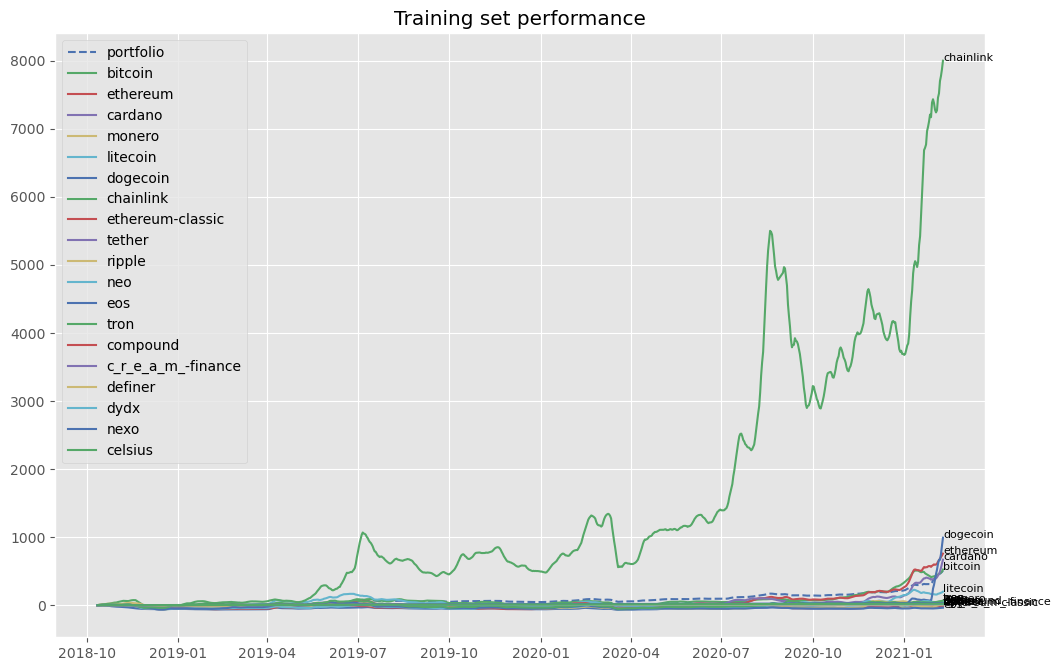

In [34]:
high_risk_weights = ef.efficient_risk(target_volatility=.30)
high_risk_weights =  ef.clean_weights()
print(high_risk_weights)
_ = evaluation(high_risk_weights, train_df, rebalance_period=30)
_ = plt.title("Training set performance")

Expected annual return: 353.4%
Annual volatility: 21.4%
Sharpe Ratio: 16.44


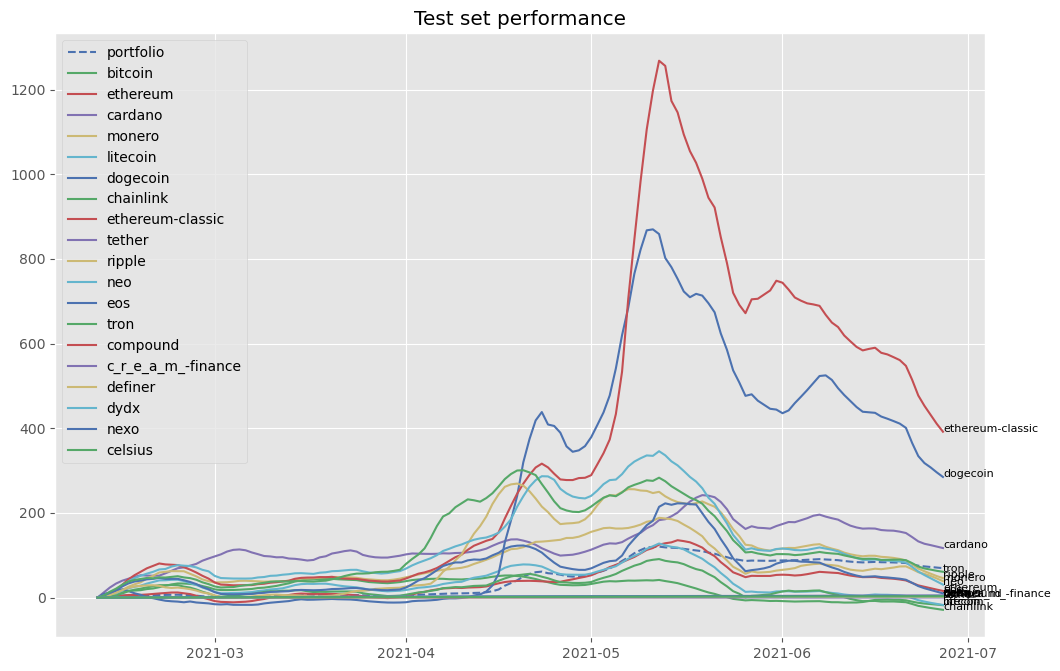

In [35]:
high_risk_roi = evaluation(high_risk_weights, test_df, rebalance_period=30)
_ = plt.title("Test set performance")

In [27]:
roi_df = pd.DataFrame({"low_risk" : low_risk_roi,
                      "med_risk" : med_risk_roi,
                      "high_risk" : high_risk_roi})
roi_df.index = test_df.index
roi_df.to_csv("../data/portfolios/2021-07-08.csv")
assets_df.to_csv("../data/clean_data/2021-07-08.csv")